<a href="https://colab.research.google.com/github/xmaslzq/Tiktok-TechJam-2025/blob/main/Techjam1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
import pandas as pd
# ===Step 1: Load Public Dataset ===
# Kaggle dataset path (modify according to your actual file name)
df = pd.read_csv("/content/reviews.csv")

# Preview original data
print("Original data sample:")
print(df.head())

# === Step 2: Data Cleaning ===
# 1. Remove rows where review_text is empty
df = df.dropna(subset=["text"])

# 2. Remove duplicate reviews
df = df.drop_duplicates(subset=["text"])

# 3. Check that required columns exist
required_columns = ["text"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# 4. Check optional columns
optional_columns = ["rating", "user_id"]
for col in optional_columns:
    if col not in df.columns:
        print(f"Optional column missing: {col}, will handle later if needed")

# Save cleaned data to a new CSV
df.to_csv("google_reviews_cleaned.csv", index=False)

# Preview cleaned data
print("Cleaned data sample:")
print(df.head())
print(f"Total reviews after cleaning: {len(df)}")


Original data sample:
                     business_name    author_name  \
0  Haci'nin Yeri - Yigit Lokantasi    Gulsum Akar   
1  Haci'nin Yeri - Yigit Lokantasi  Oguzhan Cetin   
2  Haci'nin Yeri - Yigit Lokantasi     Yasin Kuyu   
3  Haci'nin Yeri - Yigit Lokantasi     Orhan Kapu   
4  Haci'nin Yeri - Yigit Lokantasi     Ozgur Sati   

                                                text  \
0  We went to Marmaris with my wife for a holiday...   
1  During my holiday in Marmaris we ate here to f...   
2  Prices are very affordable. The menu in the ph...   
3  Turkey's cheapest artisan restaurant and its f...   
4  I don't know what you will look for in terms o...   

                                               photo  rating  \
0         dataset/taste/hacinin_yeri_gulsum_akar.png       5   
1        dataset/menu/hacinin_yeri_oguzhan_cetin.png       4   
2  dataset/outdoor_atmosphere/hacinin_yeri_yasin_...       3   
3  dataset/indoor_atmosphere/hacinin_yeri_orhan_k...       5   
4 

In [ ]:
!pip install textblob scikit-learn
import pandas as pd
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

#Load Cleaned Dataset ===
df = pd.read_csv("google_reviews_cleaned.csv")
print("Cleaned data sample:")
print(df.head())

#Feature Engineering ===

## --- Metadata Features ---
# 1. Review length (in words)
df["review_length"] = df["text"].apply(lambda x: len(str(x).split()))

# 2. Contains URL (possible spam/ads)
df["contains_url"] = df["text"].apply(lambda x: 1 if "http" in str(x).lower() else 0)

# 3. Contains phone number
phone_pattern =re.compile(r"\+?\d[\d\s\-\(\)]{7,}\d")
df["contains_phone"] = df["text"].apply(lambda x: 1 if phone_pattern.search(str(x)) else 0)

# 4. User review count (if author_name available)
if "author_name" in df.columns:
    user_review_counts = df["author_name"].value_counts().to_dict()
    df["user_review_count"] = df["author_name"].map(user_review_counts)
else:
    df["user_review_count"] = None

## --- Textual (NLP) Features ---
# 5. Sentiment score (polarity: -1 = negative, +1 = positive)
df["sentiment"] = df["text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# 6. Simple topic indicator (example: food, service, price, atmosphere)
topics = {
    "food": ["food", "taste", "menu", "dish", "meal", "delicious"],
    "service": ["service", "staff", "waiter", "friendly", "rude"],
    "price": ["price", "cheap", "expensive", "value", "affordable"],
    "atmosphere": ["atmosphere", "environment", "place", "ambience", "music"]
}

def detect_topic(text):
    text = str(text).lower()
    detected = [t for t, kws in topics.items() if any(kw in text for kw in kws)]
    return ", ".join(detected) if detected else "other"

df["topics"] = df["text"].apply(detect_topic)

# 7. Keyword extraction using TF-IDF (just top keywords across dataset)
vectorizer = TfidfVectorizer(max_features=20, stop_words="english")
X = vectorizer.fit_transform(df["text"].astype(str))
keywords = vectorizer.get_feature_names_out()
print("Top keywords (TF-IDF):", keywords)

#Save Enhanced Dataset ===
df.to_csv("google_reviews_with_features.csv", index=False)
print("Enhanced dataset saved as google_reviews_with_features.csv")
print(df.head(10))


Cleaned data sample:
                     business_name    author_name  \
0  Haci'nin Yeri - Yigit Lokantasi    Gulsum Akar   
1  Haci'nin Yeri - Yigit Lokantasi  Oguzhan Cetin   
2  Haci'nin Yeri - Yigit Lokantasi     Yasin Kuyu   
3  Haci'nin Yeri - Yigit Lokantasi     Orhan Kapu   
4  Haci'nin Yeri - Yigit Lokantasi     Ozgur Sati   

                                                text  \
0  We went to Marmaris with my wife for a holiday...   
1  During my holiday in Marmaris we ate here to f...   
2  Prices are very affordable. The menu in the ph...   
3  Turkey's cheapest artisan restaurant and its f...   
4  I don't know what you will look for in terms o...   

                                               photo  rating  \
0         dataset/taste/hacinin_yeri_gulsum_akar.png       5   
1        dataset/menu/hacinin_yeri_oguzhan_cetin.png       4   
2  dataset/outdoor_atmosphere/hacinin_yeri_yasin_...       3   
3  dataset/indoor_atmosphere/hacinin_yeri_orhan_k...       5   
4  

In [ ]:
# Load enhanced dataset
df = pd.read_csv("google_reviews_with_features.csv")

# === Policy Enforcement ===

# 1. No Advertisement (contains URL or phone)
df["violates_ad"] = df.apply(lambda x: 1 if x["contains_url"] == 1 or x["contains_phone"] == 1 else 0, axis=1)

# 2. No Irrelevant Content (simple topic-based heuristic: if topic == 'other')
df["violates_irrelevant"] = df["topics"].apply(lambda x: 1 if x == "other" else 0)

# 3. No Rant Without Visit (simple heuristic: negative sentiment and very short review length)
# Can be refined later with NLP or LLM
df["violates_rant_no_visit"] = df.apply(lambda x: 1 if x["sentiment"] < -0.6 and x["review_length"] < 5 else 0, axis=1)

# Summary counts
print("Policy violation counts:")
print(df[["violates_ad", "violates_irrelevant", "violates_rant_no_visit"]].sum())

# Save dataset with policy flags
df.to_csv("google_reviews_with_policy_flags.csv", index=False)
print("Dataset with policy flags saved as google_reviews_with_policy_flags.csv")


Policy violation counts:
violates_ad                 0
violates_irrelevant       265
violates_rant_no_visit      1
dtype: int64
Dataset with policy flags saved as google_reviews_with_policy_flags.csv


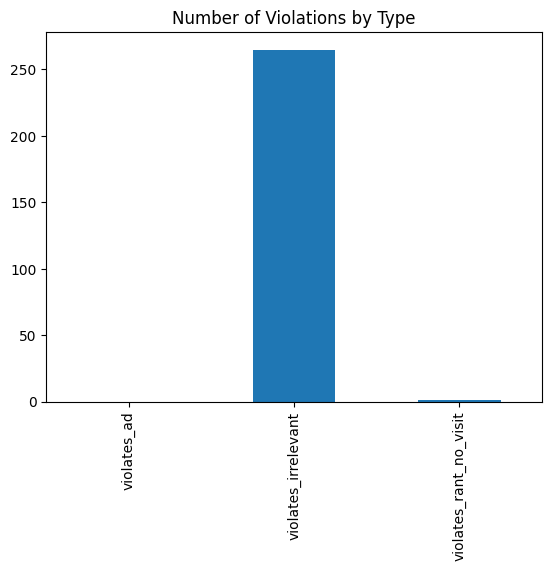

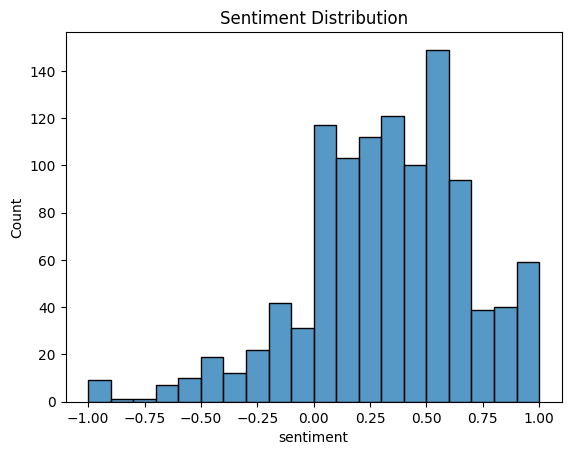

In [ ]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("google_reviews_with_policy_flags.csv")

# Policy violation counts
violation_cols = ["violates_ad", "violates_irrelevant", "violates_rant_no_visit"]
df[violation_cols].sum().plot(kind='bar', title="Number of Violations by Type")
plt.show()

# Sentiment distribution
sns.histplot(df["sentiment"], bins=20)
plt.title("Sentiment Distribution")
plt.show()


In [1]:
# classify_reviews.py
!pip install openai pandas tqdm backoff tldextract


import os
import json
import argparse
import time
from typing import Dict, Any, Optional

import pandas as pd
import openai
from tqdm import tqdm
import backoff
import tldextract  # optional: helps detect links (used in prompt examples)

# ---------------------------
# Configuration / Defaults
# ---------------------------
DEFAULT_MODEL = "gpt-4o-mini"   # keep or change
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("Set OPENAI_API_KEY environment variable before running the script.")
openai.api_key = OPENAI_API_KEY

# Max retries on API errors
MAX_RETRIES = 5

# ---------------------------
# Helper: resilient API call (with backoff)
# ---------------------------
def is_retryable_exception(e: Exception) -> bool:
    # Basic classification for retryable errors; extend if needed
    msg = str(e).lower()
    for token in ["rate limit", "timeout", "503", "502", "timeout", "timed out", "server error", "connection reset"]:
        if token in msg:
            return True
    return False

@backoff.on_exception(
    backoff.expo,
    Exception,
    max_tries=MAX_RETRIES,
    giveup=lambda e: not is_retryable_exception(e)
)
def call_openai_chat(messages, functions=None, function_call=None, model=DEFAULT_MODEL, temperature=0.0, max_tokens=512):
    """
    Wrapper for OpenAI ChatCompletion with optional function calling.
    Uses exponential backoff for transient errors.
    """
    # Try the widely-compatible ChatCompletion.create signature
    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=temperature,
            functions=functions,
            function_call=function_call,
            max_tokens=max_tokens
        )
        return response
    except Exception as e:
        # Some users have different naming in older/newer SDKs; try alternative call shape
        try:
            # the older 'chat.completions.create' style (if available)
            response = openai.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature,
                functions=functions,
                function_call=function_call,
                max_tokens=max_tokens
            )
            return response
        except Exception:
            # re-raise so backoff can handle it
            raise

# ---------------------------
# Prompt / function schema
# ---------------------------
FUNCTION_SCHEMA = {
    "name": "classify_review",
    "description": "Classify a single Google review according to moderation/quality policies.",
    "parameters": {
        "type": "object",
        "properties": {
            "advertisement": {
                "type": "integer",
                "description": "1 if the review contains spam/ads/phone numbers/links, otherwise 0",
                "enum": [0, 1]
            },
            "irrelevant": {
                "type": "integer",
                "description": "1 if the review is unrelated to the business/location, otherwise 0",
                "enum": [0, 1]
            },
            "rant_no_visit": {
                "type": "integer",
                "description": "1 if the review appears to rant without evidence of visiting (e.g., 'I've heard', 'this company is a scam' with no visit indicators), otherwise 0",
                "enum": [0, 1]
            },
            "explanation": {
                "type": "string",
                "description": "Short explanation (one or two sentences) describing why the classification was chosen"
            }
        },
        "required": ["advertisement", "irrelevant", "rant_no_visit", "explanation"]
    }
}

CLASSIFICATION_SYSTEM_PROMPT = """
You are a content moderation/quality classifier. Given one short Google review text, return a JSON object with these fields:
 - advertisement: 1 if the review clearly contains spam, promotional text, phone numbers, or explicit links/URLs; otherwise 0.
 - irrelevant: 1 if the review content is unrelated to the location/business (e.g., talking about politics, general life advice, or an unrelated person); otherwise 0.
 - rant_no_visit: 1 if the review is a negative rant that indicates the author likely never visited (e.g., makes broad accusations without details, uses future-tense threats, or clearly refers to hearsay) ; otherwise 0.
 - explanation: a short human-readable explanation (max 2 sentences) saying why you chose the labels.

Return only valid JSON (or use the function-calling mechanism that returns only the arguments JSON). Be concise in the explanation.
"""

# ---------------------------
# Core classification function
# ---------------------------
def classify_single_review(review_text: str, model: str = DEFAULT_MODEL) -> Dict[str, Any]:
    """
    Uses OpenAI function-calling to get structured JSON back reliably.
    """
    # Clean and shorten the text for the prompt to avoid unexpected tokens
    review_clean = str(review_text).replace("\n", " ").strip()
    if len(review_clean) > 2000:
        review_clean = review_clean[:2000] + " [TRUNCATED]"

    messages = [
        {"role": "system", "content": CLASSIFICATION_SYSTEM_PROMPT},
        {"role": "user", "content": f'Review: "{review_clean}"\n\nClassify it now.'}
    ]

    # Ask the model to call the function and return its arguments (pure JSON)
    response = call_openai_chat(
        messages=messages,
        functions=[FUNCTION_SCHEMA],
        function_call={"name": "classify_review"},
        model=model,
        temperature=0.0,
        max_tokens=512
    )

    # Extract JSON arguments from response robustly
    choice = response["choices"][0]
    message = choice.get("message", choice.get("finish_reason", {}))  # defensive
    json_text = None

    # If function_call present, its 'arguments' field is the JSON string
    if "message" in choice and isinstance(choice["message"], dict) and choice["message"].get("function_call"):
        fc = choice["message"]["function_call"]
        json_text = fc.get("arguments", "")
    else:
        # fallback: assistant content
        json_text = choice.get("message", {}).get("content", "") or choice.get("text", "")

    # Try to load JSON; if the model adds extra text, extract the JSON object substring
    try:
        parsed = json.loads(json_text)
    except Exception:
        # fallback: find the first { ... } substring and parse
        import re
        m = re.search(r"\{.*\}", json_text, flags=re.DOTALL)
        if m:
            try:
                parsed = json.loads(m.group(0))
            except Exception as e:
                # give a safe fallback
                parsed = {"advertisement": None, "irrelevant": None, "rant_no_visit": None, "explanation": None}
        else:
            parsed = {"advertisement": None, "irrelevant": None, "rant_no_visit": None, "explanation": None}

    # Normalize values: ensure ints 0/1 and explanation as string
    def norm_flag(v) -> Optional[int]:
        if v in (0, "0", False, "false", "False"):
            return 0
        if v in (1, "1", True, "true", "True"):
            return 1
        try:
            iv = int(v)
            return 1 if iv != 0 else 0
        except Exception:
            return None

    result = {
        "advertisement": norm_flag(parsed.get("advertisement")),
        "irrelevant": norm_flag(parsed.get("irrelevant")),
        "rant_no_visit": norm_flag(parsed.get("rant_no_visit")),
        "explanation": str(parsed.get("explanation")) if parsed.get("explanation") is not None else None
    }
    return result

# ---------------------------
# Batch processing & CLI
# ---------------------------
def process_file(input_csv: str, output_csv: str, text_col: str = "text", model: str = DEFAULT_MODEL, start: int = 0, end: Optional[int] = None):
    df = pd.read_csv(input_csv)
    if text_col not in df.columns:
        raise KeyError(f"Text column '{text_col}' not found in {input_csv}. Columns: {df.columns.tolist()}")

    # Create result columns
    for c in ["advertisement", "irrelevant", "rant_no_visit", "explanation"]:
        if c not in df.columns:
            df[c] = None

    # process rows
    total = len(df) if end is None else min(end, len(df))
    rows_to_process = range(start, total)
    for i in tqdm(rows_to_process, desc="Classifying reviews"):
        if pd.notna(df.at[i, "advertisement"]) and pd.notna(df.at[i, "irrelevant"]) and pd.notna(df.at[i, "rant_no_visit"]):
            # skip already-labeled rows
            continue
        try:
            res = classify_single_review(df.at[i, text_col], model=model)
        except Exception as e:
            # if one review fails repeatedly, don't stop the entire batch
            print(f"Error classifying row {i}: {e}")
            res = {"advertisement": None, "irrelevant": None, "rant_no_visit": None, "explanation": None}

        df.at[i, "advertisement"] = res["advertisement"]
        df.at[i, "irrelevant"] = res["irrelevant"]
        df.at[i, "rant_no_visit"] = res["rant_no_visit"]
        df.at[i, "explanation"] = res["explanation"]

        # optional: write incrementally to avoid losing progress (every 50 rows)
        if (i - start + 1) % 50 == 0:
            df.to_csv(output_csv, index=False)
    # final save
    df.to_csv(output_csv, index=False)
    print("Saved results to", output_csv)
    return df

# ---------------------------
# Main / CLI
# ---------------------------
def main():
    parser = argparse.ArgumentParser(description="Classify Google reviews using OpenAI")
    parser.add_argument("--input", required=True, help="Input CSV file with a 'text' column (reviews)")
    parser.add_argument("--output", required=True, help="Output CSV file (will be overwritten)")
    parser.add_argument("--text-col", default="text", help="Name of the text column in the CSV")
    parser.add_argument("--model", default=DEFAULT_MODEL, help="OpenAI model to use")
    parser.add_argument("--start", type=int, default=0, help="Row index to start processing (0-based)")
    parser.add_argument("--end", type=int, default=None, help="Row index to stop (exclusive)")
    args = parser.parse_args()

    process_file(args.input, args.output, text_col=args.text_col, model=args.model, start=args.start, end=args.end)

if __name__ == "__main__":
    main()


Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unloc

KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Load classified data
df_classified = pd.read_csv("reviews_with_policy.csv")

# Keep only “clean” reviews
df_clean = df_classified[
    (df_classified['advertisement'] == 0) &
    (df_classified['irrelevant'] == 0) &
    (df_classified['rant_no_visit'] == 0)&
    (df_classified['vagueness'] == 0)
].copy()

# Optional: save
df_clean.to_csv("google_reviews_policy_clean.csv", index=False)


=== Useful comments count ===
{'Original': np.int64(823), 'Clean': 809}


/tmp/ipython-input-2848458993.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(useful_counts.keys()), y=list(useful_counts.values()), palette='viridis')


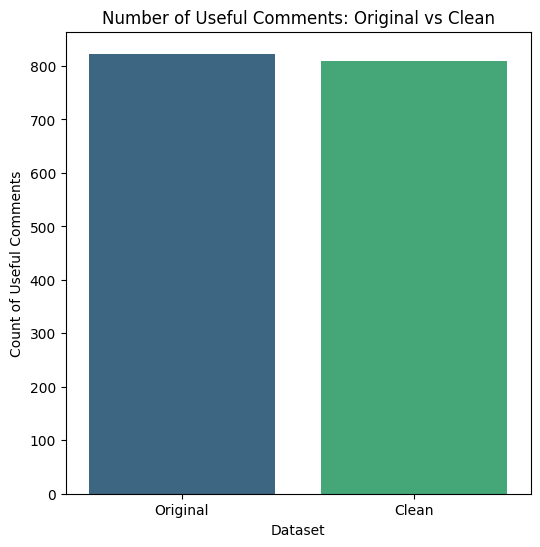

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_original = pd.read_csv("google_reviews_with_policy_flags.csv")
df_clean = pd.read_csv("google_reviews_policy_clean.csv")

# Count "useful comments" (all four flags are 0)
def count_useful(df):
    # 对应你的实际列名
    cols = ['violates_ad', 'violates_irrelevant', 'violates_rant_no_visit']
    for col in cols:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            return 0
    return ((df['violates_ad'] == 0) &
            (df['violates_irrelevant'] == 0) &
            (df['violates_rant_no_visit'] == 0)).sum()

# Compute useful comments for original dataset
useful_original = count_useful(df_original)

# Compute useful comments for clean dataset (already filtered)
useful_clean = len(df_clean)

useful_counts = {
    'Original': useful_original,
    'Clean': useful_clean
}

print("=== Useful comments count ===")
print(useful_counts)

# Plot comparison
plt.figure(figsize=(6,6))
sns.barplot(x=list(useful_counts.keys()), y=list(useful_counts.values()), palette='viridis')
plt.title("Number of Useful Comments: Original vs Clean")
plt.ylabel("Count of Useful Comments")
plt.xlabel("Dataset")
plt.show()


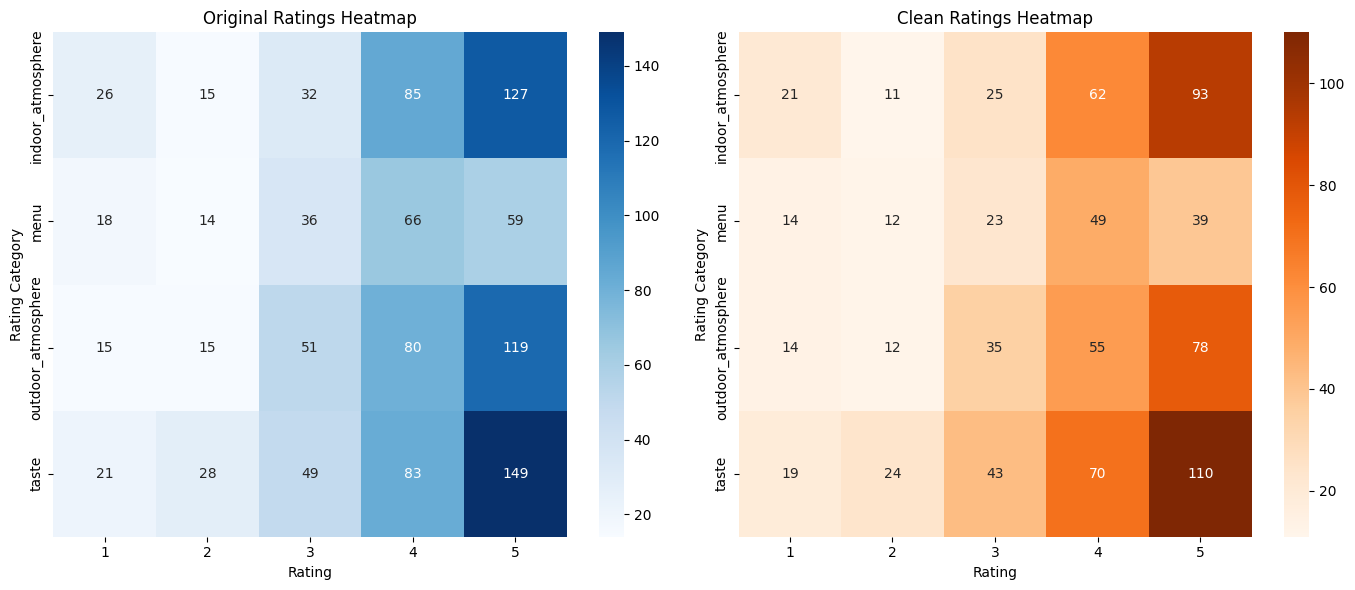

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_original = pd.read_csv("google_reviews_with_policy_flags.csv")
df_clean = pd.read_csv("google_reviews_policy_clean.csv")

# Step 1: Create a pivot table: count of ratings per category
pivot_original = df_original.pivot_table(index='rating_category', columns='rating', aggfunc='size', fill_value=0)
pivot_clean = df_clean.pivot_table(index='rating_category', columns='rating', aggfunc='size', fill_value=0)

# Step 2: Plot heatmaps
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.heatmap(pivot_original, annot=True, fmt='d', cmap='Blues')
plt.title("Original Ratings Heatmap")
plt.ylabel("Rating Category")
plt.xlabel("Rating")

plt.subplot(1,2,2)
sns.heatmap(pivot_clean, annot=True, fmt='d', cmap='Oranges')
plt.title("Clean Ratings Heatmap")
plt.ylabel("Rating Category")
plt.xlabel("Rating")

plt.tight_layout()
plt.show()


/tmp/ipython-input-3050488735.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=violation_counts_original.values, y=violation_counts_original.index, palette="viridis")


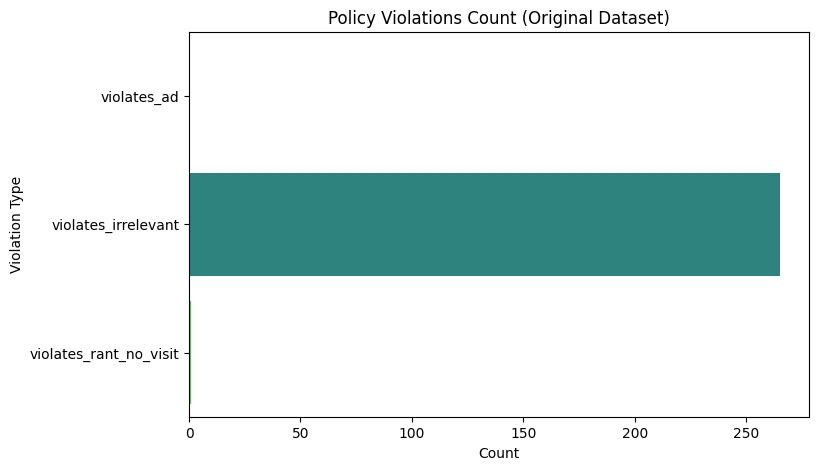

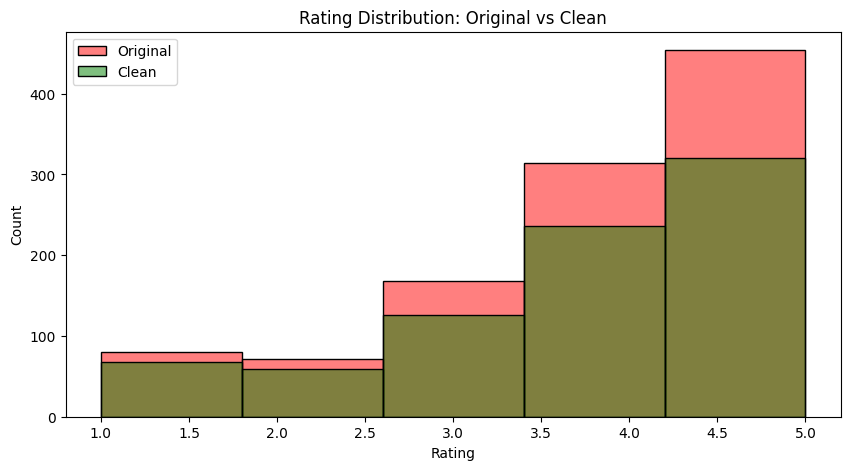

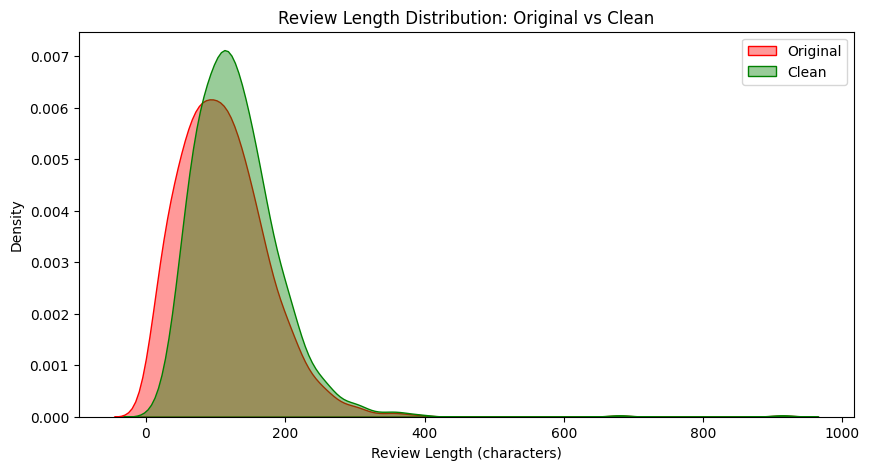

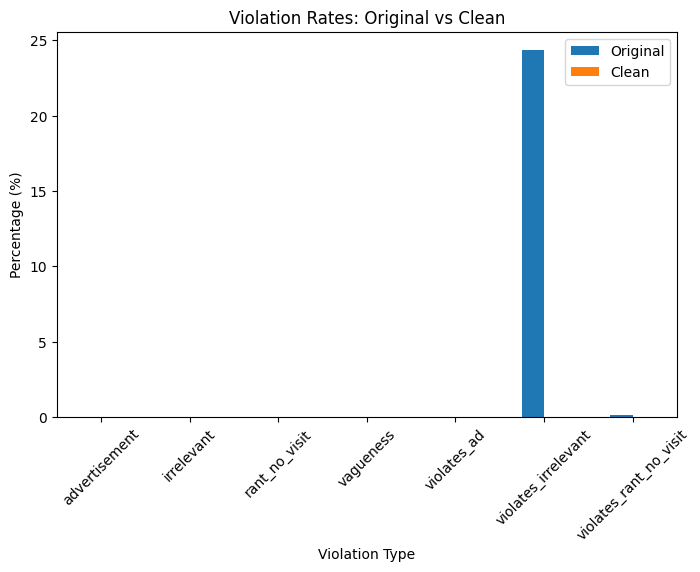

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load datasets ===
df_original = pd.read_csv("google_reviews_with_policy_flags.csv")
df_clean = pd.read_csv("google_reviews_policy_clean.csv")

# Strip spaces in column names (just in case)
df_original.columns = df_original.columns.str.strip()
df_clean.columns = df_clean.columns.str.strip()

# === 1. Policy Violations Distribution ===
# Original dataset violation columns
violation_cols_original = ['violates_ad', 'violates_irrelevant', 'violates_rant_no_visit']

# Clean dataset violation columns
violation_cols_clean = ['advertisement', 'irrelevant', 'rant_no_visit', 'vagueness']

# Count violations in original dataset
violation_counts_original = df_original[violation_cols_original].sum()


# Horizontal bar chart - original dataset
plt.figure(figsize=(8,5))
sns.barplot(x=violation_counts_original.values, y=violation_counts_original.index, palette="viridis")
plt.title("Policy Violations Count (Original Dataset)")
plt.xlabel("Count")
plt.ylabel("Violation Type")
plt.show()


# === 2. Before vs After Filtering Comparison ===

# 2a. Rating distribution
plt.figure(figsize=(10,5))
sns.histplot(df_original['rating'], bins=5, color="red", alpha=0.5, label="Original")
sns.histplot(df_clean['rating'], bins=5, color="green", alpha=0.5, label="Clean")
plt.title("Rating Distribution: Original vs Clean")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.legend()
plt.show()

# 2b. Review length distribution
df_original['review_length'] = df_original['text'].astype(str).str.len()
df_clean['review_length'] = df_clean['text'].astype(str).str.len()

plt.figure(figsize=(10,5))
sns.kdeplot(df_original['review_length'], color="red", label="Original", fill=True, alpha=0.4)
sns.kdeplot(df_clean['review_length'], color="green", label="Clean", fill=True, alpha=0.4)
plt.title("Review Length Distribution: Original vs Clean")
plt.xlabel("Review Length (characters)")
plt.ylabel("Density")
plt.legend()
plt.show()

# 2c. Violation rates (percentage)
violation_rate_original = (df_original[violation_cols_original].sum() / len(df_original)) * 100
violation_rate_clean = (df_clean[violation_cols_clean].sum() / len(df_clean)) * 100

violation_compare = pd.DataFrame({
    "Original": violation_rate_original,
    "Clean": violation_rate_clean
})

violation_compare.plot(kind="bar", figsize=(8,5))
plt.title("Violation Rates: Original vs Clean")
plt.ylabel("Percentage (%)")
plt.xlabel("Violation Type")
plt.xticks(rotation=45)
plt.show()


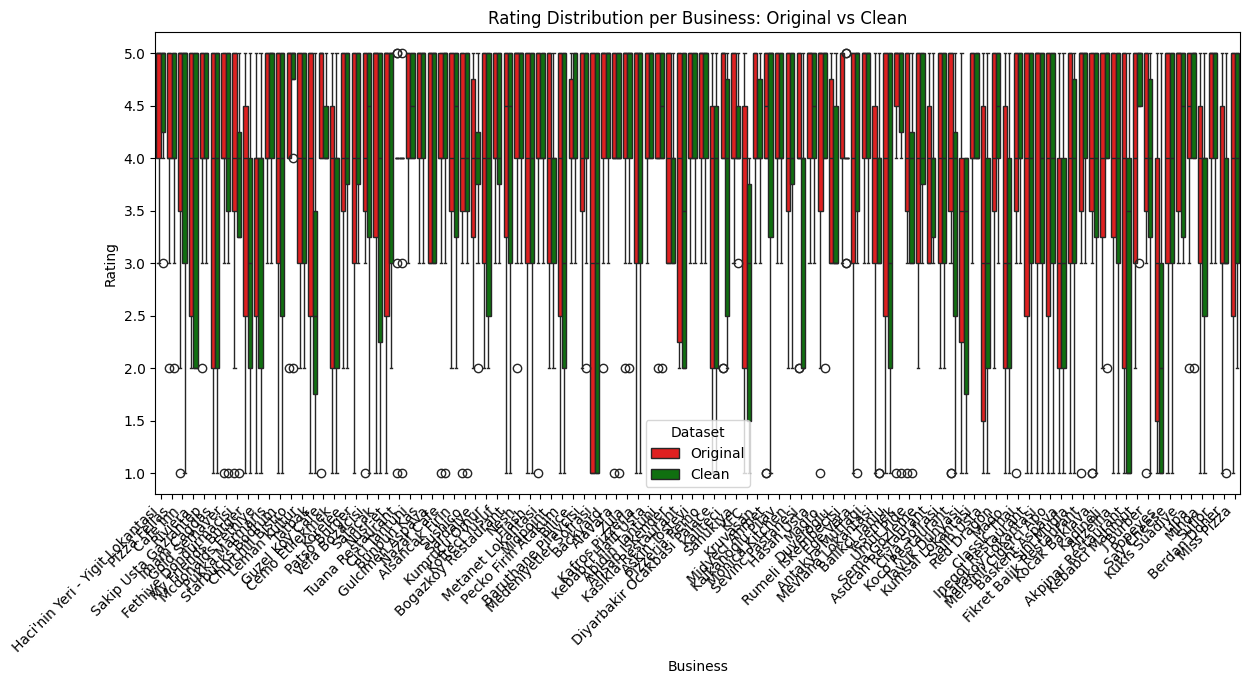

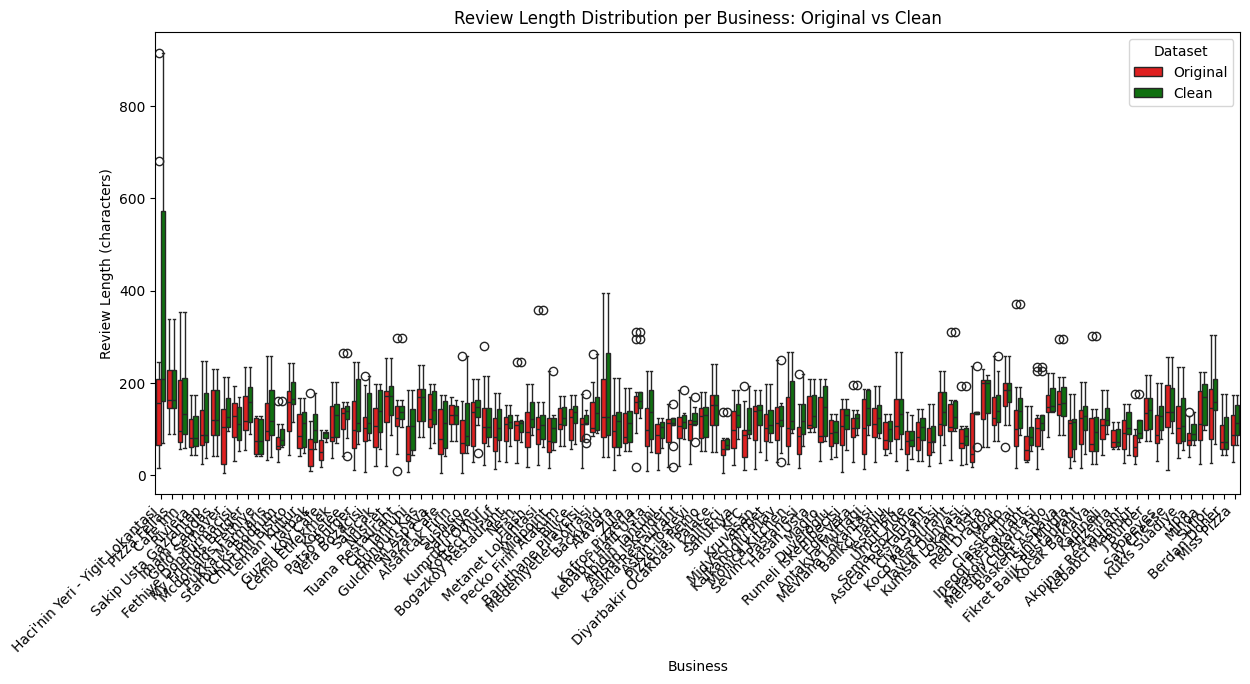

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_original = pd.read_csv("google_reviews_with_policy_flags.csv")
df_clean = pd.read_csv("google_reviews_policy_clean.csv")

# Clean column names
df_original.columns = df_original.columns.str.strip()
df_clean.columns = df_clean.columns.str.strip()

# Add a column to indicate dataset
df_original['dataset'] = 'Original'
df_clean['dataset'] = 'Clean'

# Compute review length
df_original['review_length'] = df_original['text'].astype(str).str.len()
df_clean['review_length'] = df_clean['text'].astype(str).str.len()

# Concatenate datasets for comparison
df_combined = pd.concat([df_original, df_clean], ignore_index=True)

# === Boxplot: Ratings per Business, side-by-side ===
plt.figure(figsize=(14,6))
sns.boxplot(x="business_name", y="rating", hue="dataset", data=df_combined, palette=["red","green"])
plt.title("Rating Distribution per Business: Original vs Clean")
plt.xlabel("Business")
plt.ylabel("Rating")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset")
plt.show()

# === Boxplot: Review Length per Business, side-by-side ===
plt.figure(figsize=(14,6))
sns.boxplot(x="business_name", y="review_length", hue="dataset", data=df_combined, palette=["red","green"])
plt.title("Review Length Distribution per Business: Original vs Clean")
plt.xlabel("Business")
plt.ylabel("Review Length (characters)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset")
plt.show()


/tmp/ipython-input-3061240820.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=violation_stats.index, y=violation_stats['violation_rate'], palette="magma")


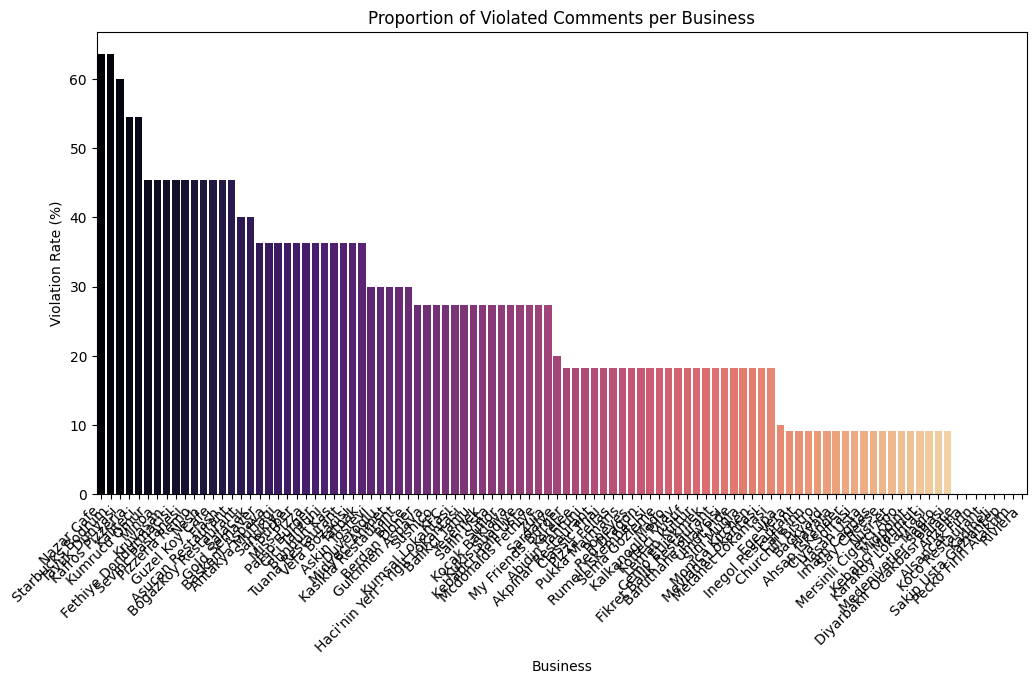

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df_original = pd.read_csv("google_reviews_with_policy_flags.csv")
df_original.columns = df_original.columns.str.strip()

# Correct violation columns based on actual CSV
violation_cols = ['violates_ad', 'violates_irrelevant', 'violates_rant_no_visit', 'vagueness']

# If 'vagueness' does not exist in your CSV, remove it from the list
violation_cols = [col for col in violation_cols if col in df_original.columns]

# Compute total violations per comment (any violation)
df_original['total_violation'] = df_original[violation_cols].sum(axis=1) > 0

# Compute number and proportion of violated comments per company
violation_stats = df_original.groupby('business_name')['total_violation'].agg(['sum','count'])
violation_stats['violation_rate'] = violation_stats['sum'] / violation_stats['count'] * 100

# Sort by violation_rate descending
violation_stats = violation_stats.sort_values('violation_rate', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=violation_stats.index, y=violation_stats['violation_rate'], palette="magma")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Violation Rate (%)")
plt.xlabel("Business")
plt.title("Proportion of Violated Comments per Business")
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1️⃣ Load dataset
df = pd.read_csv("google_reviews_with_policy_flags.csv")
df.columns = df.columns.str.strip()

# 2️⃣ Feature engineering
df['review_length'] = df['text'].astype(str).str.len()
df['num_words'] = df['text'].astype(str).str.split().apply(len)

# 3️⃣ Categorical features
categorical_cols = ['business_name', 'rating_category']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 4️⃣ Define features and targets
feature_cols = [col for col in df_encoded.columns if col not in [
    'text', 'photo', 'violates_ad', 'violates_irrelevant', 'violates_rant_no_visit'
]]
X = df_encoded[feature_cols]

y = df_encoded[['violates_ad', 'violates_irrelevant', 'violates_rant_no_visit']]

# 5️⃣ Ensure numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# 6️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7️⃣ Train separate RandomForest for each violation type
models = {}
for col in y.columns:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train[col])
    models[col] = clf

# 8️⃣ Predict on test set
y_pred = pd.DataFrame({col: models[col].predict(X_test) for col in y.columns})

# 9️⃣ Evaluate
for col in y.columns:
    print(f"--- {col} ---")
    print(classification_report(y_test[col], y_pred[col]))


--- violates_ad ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218

    accuracy                           1.00       218
   macro avg       1.00      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218

--- violates_irrelevant ---
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       165
           1       0.31      0.09      0.14        53

    accuracy                           0.73       218
   macro avg       0.54      0.51      0.49       218
weighted avg       0.65      0.73      0.67       218

--- violates_rant_no_visit ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       0.00      0.00      0.00         1

    accuracy                           1.00       218
   macro avg       0.50      0.50      0.50       218
weighted avg       0.99      1.00      0.99      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
